<a href="https://colab.research.google.com/github/mrch-hub/bangkit1/blob/test_neuralnet/SolarPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Solar radiation intensity prediction using TensorFlow

In [0]:
"""A python code for predicting solar radiation
intensity using TensorFlow. Created for 
5th Bangk!t assignment.
Collaborators: Marcellinus Chrisnada, Muhammad
Harits Hafidza, Mochammad Randy Caesario H."""

'A python code for predicting solar radiation\nintensity using TensorFlow. Created for \n5th Bangk!t assignment.\nCollaborators: Marcellinus Chrisnada, Muhammad\nHarits Hafidza, Mochammad Randy Caesario H.'

##Initialization

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
#@title Import relevant modules
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# Adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#@title Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/mrch-hub/bangkit1/master/SolarPrediction.csv')
data = data.reindex(np.random.permutation(data.index)) # shuffle dataset
data.head(40)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
8585,1477643118,10/27/2016 12:00:00 AM,22:25:18,1.2,45,30.4,93,181.2,2.2,06:22:00,17:51:00
11586,1476740417,10/17/2016 12:00:00 AM,11:40:17,988.3,64,30.5,35,23.4,12.4,06:18:00,17:58:00
5348,1473483620,9/9/2016 12:00:00 AM,19:00:20,1.7,50,30.4,100,136.8,2.2,06:09:00,18:31:00
29381,1481803202,12/15/2016 12:00:00 AM,02:00:02,1.3,38,30.2,63,251.6,2.2,06:50:00,17:46:00
26748,1482595550,12/24/2016 12:00:00 AM,06:05:50,1.2,45,30.4,81,168.9,9.0,06:54:00,17:50:00
...,...,...,...,...,...,...,...,...,...,...,...
19477,1479509421,11/18/2016 12:00:00 AM,12:50:21,909.9,61,30.4,35,337.9,6.8,06:33:00,17:43:00
14471,1475856927,10/7/2016 12:00:00 AM,06:15:27,6.9,45,30.4,86,174.7,6.8,06:15:00,18:06:00
5720,1473256223,9/7/2016 12:00:00 AM,03:50:23,2.8,43,30.4,66,159.6,2.2,06:08:00,18:33:00
2630,1474422309,9/20/2016 12:00:00 AM,15:45:09,285.6,57,30.4,90,0.1,5.6,06:11:00,18:21:00


##Adding some features to the dataset

In [0]:
#@title Adding feature is_daylight that define measurement time is either daylight (1) or nighttime (0)
is_daylight = [data['Time'].values[x] > data['TimeSunRise'].values[x] and data['Time'].values[x] < data['TimeSunSet'].values[x] for x in range(len(data))]
data['is_daylight'] = is_daylight
data['is_daylight'] = data['is_daylight'].astype('float')

In [0]:
#@title Convert UNIXTime into hour, day, month format
data['Time_Convert'] = pd.to_datetime(data['Time'], format = '%H:%M:%S')

data['Hour'] = pd.to_datetime(data['Time_Convert'], format = '%H:%M:%S').dt.hour # Get the hour of the day

data['Day'] = pd.to_datetime(data['UNIXTime'].astype(int), unit = 's').dt.day # Get the day of the month

data['Month'] = pd.to_datetime(data['UNIXTime'].astype(int), unit = 's').dt.month # Get the month of the year

##Data Preconditioning

In [0]:
#@title Splitting data to train set and test set
test_split = 0.2 # percentage of train set to be considered as test set
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]
print('train set length:', str(len(data_train)), '\ntest set length:', 
      str(len(data_test)))

train set length: 26149 
test set length: 6537


In [0]:
#@title Normalize values 

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train.select_dtypes(include=['float64', 'int64']).mean()
data_train_std = data_train.select_dtypes(include=['float64', 'int64']).std()
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                   - data_train_mean)/data_train_std
data_train_norm['WindDirection'] = data_train_norm['WindDirection(Degrees)']

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test.select_dtypes(include=['float64', 'int64']).mean()
data_test_std = data_test.select_dtypes(include=['float64', 'int64']).std()
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                  - data_test_mean)/data_test_std
data_test_norm['WindDirection'] = data_test_norm['WindDirection(Degrees)']


print("Normalized the values.")

Normalized the values.


## Represent data

The following code cell creates a feature layer containing these features:

* `Temperature`
* `Pressure`
* `is_daylight`
* `Day`
* `Hour`
* `Month`
* `Humidity`
* `WindDirection`

In [0]:
# Create empty feature column list
feature_columns = []

# Represent Temperature as a floating-point value.
temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

# Represent Pressure as a floating-point value.
pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

# Represent Daylight as a floating-point value.
daylight = tf.feature_column.numeric_column("is_daylight")
feature_columns.append(daylight)

# Represent Hour as a floating-point value.
day = tf.feature_column.numeric_column("Day")
feature_columns.append(day)

# Represent Hour as a floating-point value.
hour = tf.feature_column.numeric_column("Hour")
feature_columns.append(hour)

# Represent Hour as a floating-point value.
month = tf.feature_column.numeric_column("Month")
feature_columns.append(month)

# Represent Humidity as a floating-point value.
humidity = tf.feature_column.numeric_column("Humidity")
feature_columns.append(humidity)

# Represent WindDirection as a floating-point value.
windir = tf.feature_column.numeric_column("WindDirection")
feature_columns.append(windir)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model

In [0]:
#@title Define plotting function

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mse_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mse_validation[1:], label="Validation Loss")
  plt.legend()

  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [0]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name,validation_split):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, 
                      shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

21/21 [==============================] - 0s 10ms/step - loss: 3.5351 - root_mean_squared_error: 1.8814 - val_loss: 2.2496 - val_root_mean_squared_error: 1.4937
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 1.5053 - root_mean_squared_error: 1.2277 - val_loss: 0.9729 - val_root_mean_squared_error: 0.9834
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.6667 - root_mean_squared_error: 0.8171 - val_loss: 0.4903 - val_root_mean_squared_error: 0.69

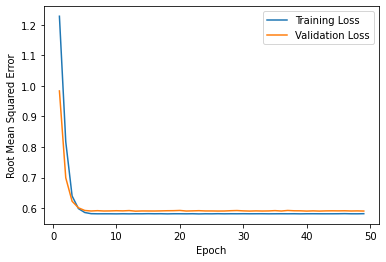


 Evaluate the linear regression model against the test set:
7/7 [==============================] - 0s 2ms/step - loss: 0.3505 - root_mean_squared_error: 0.5918


[0.3505096137523651, 0.5918421745300293]

In [0]:
#@title Train the model as linear regression
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 1000
validation_split = 0.2
label_name = "Radiation"
 

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, data_train_norm, epochs, batch_size, label_name, 
                          validation_split=validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

##Build a neural net model

In [0]:
#@title Define functions to create and train a neural net model
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 10 nodes.   
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='sigmoid',
                                  name='Hidden1'))
  
  # Define the second hidden layer with 5 nodes. 
  model.add(tf.keras.layers.Dense(units=5, 
                                  activation='sigmoid', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, dataset, epochs, label_name,
                batch_size, validation_split):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history 

Epoch 1/1200
11/11 [==============================] - 0s 20ms/step - loss: 1.7679 - root_mean_squared_error: 1.3417 - val_loss: 1.0493 - val_root_mean_squared_error: 1.0250
Epoch 2/1200
11/11 [==============================] - 0s 7ms/step - loss: 0.8638 - root_mean_squared_error: 0.9299 - val_loss: 0.7953 - val_root_mean_squared_error: 0.8932
Epoch 3/1200
11/11 [==============================] - 0s 7ms/step - loss: 0.7440 - root_mean_squared_error: 0.8632 - val_loss: 0.7270 - val_root_mean_squared_error: 0.8539
Epoch 4/1200
11/11 [==============================] - 0s 8ms/step - loss: 0.6499 - root_mean_squared_error: 0.8072 - val_loss: 0.6155 - val_root_mean_squared_error: 0.7852
Epoch 5/1200
11/11 [==============================] - 0s 8ms/step - loss: 0.5537 - root_mean_squared_error: 0.7442 - val_loss: 0.5305 - val_root_mean_squared_error: 0.7284
Epoch 6/1200
11/11 [==============================] - 0s 7ms/step - loss: 0.4774 - root_mean_squared_error: 0.6922 - val_loss: 0.4606 - val

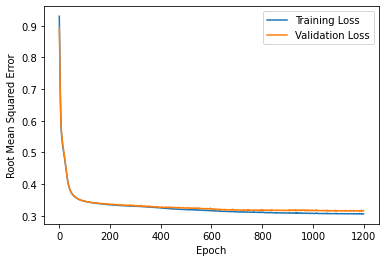


 Evaluate the linear regression model against the test set:
4/4 [==============================] - 0s 2ms/step - loss: 0.1131 - root_mean_squared_error: 0.3288


[0.11309388279914856, 0.32875949144363403]

In [0]:
#@title Train the model
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 1200
batch_size = 2000
validation_split = 0.2
label_name = "Radiation"
 

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, data_train_norm, epochs, label_name, batch_size, 
                          validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)